# Trayendo datos de poloniex y convirtiendolos en dataframe

In [56]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-09-01 00:00:00"),
                  end=string2ts("2018-02-01 00:00:00"),
                  period=3600*4)
"""
# calculando el retorno del mercado hasta el 4 quitil y del ultimo quintil
df_train = df.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:]
df_test = df.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
"""
per = 0.9
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
cum_return2 = marketReturn(df[int(len(df)*per):]["close"]) 
#cum_return1 = marketReturn(df_train)
#cum_return2 = marketReturn(df_test) 

marketReturn = cum_return1[-1]*100 
marketReturn2 = cum_return2[-1]*100

print "Retorno final del mercado: %s"%(marketReturn)
df.head()

Retorno final del mercado: 100.092114959


,close,high,low,open,quoteVolume,volume,weightedAverage,volatility
date,,,,,,,,
2017-09-01 00:00:00,0.000054,0.000055,0.000053,0.000055,24183034.048798,1307.877987,0.000054,False
2017-09-01 04:00:00,0.000053,0.000054,0.000052,0.000054,21266312.032312,1127.692091,0.000053,True
2017-09-01 08:00:00,0.000053,0.000054,0.000053,0.000053,11431568.717549,611.135504,0.000053,False
2017-09-01 12:00:00,0.000053,0.000053,0.000052,0.000053,18572566.423824,976.425733,0.000053,False
2017-09-01 16:00:00,0.000052,0.000053,0.000051,0.000053,15025387.188321,790.802831,0.000053,False


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

Retorno del mercacdo: 100.092114959
Retorno de SMA13 VS EMA5: 396.69889574
Retorno de Precio VS SMA20: 372.240221293
Retorno de Precio VS EMA5: 570.882188021


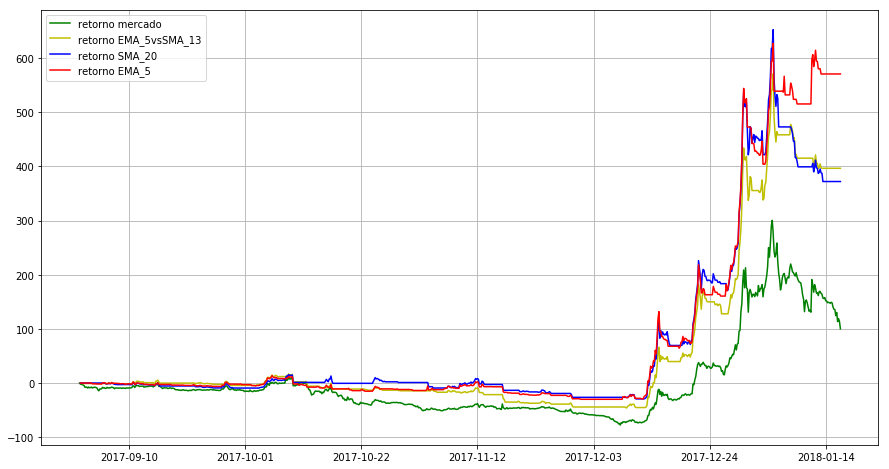

In [57]:
from strategy2 import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
wTrain = w[:int(len(df)*per)]
wTest = w[int(len(df)*per):]
relativeReturn,v = profit(wTrain)
relativeReturnTest,vTest = profit(wTest)

#Precio vs SMA_20
w3 = pricevsSMA(df['weightedAverage'],20)
w3Train = w3[:int(len(df)*per)]
w3Test = w3[int(len(df)*per):]
relativeReturn3,v3 = profit(w3Train)
relativeReturn3Test,v3Test = profit(w3Test)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
w2Train = w2[:int(len(df)*per)]
w2Test = w2[int(len(df)*per):]
relativeReturn2,v2 = profit(w2Train)
relativeReturn2Test,v2Test = profit(w2Test)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)

plt.plot(df.index[:int(len(df)*per)],cum_return1*100,'g', label='retorno mercado')
plt.plot(df.index[:int(len(df)*per)],v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[:int(len(df)*per)],v3*100,'b',label='retorno SMA_20')
plt.plot(df.index[:int(len(df)*per)],v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()


## RSI via stockstacks

In [58]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

In [59]:
from peakdetect import peakdetect

y = df['close'].values
x = df.index[:].values

_max, _min = peakdetect(y, x, 3)

xm = [p[0] for p in _max]
ym = [p[1] for p in _max]
xn = [p[0] for p in _min]
yn = [p[1] for p in _min]




## Indicadores via TA-Lib

In [60]:
#import talib

#df["fastk"], df["fastd"] = talib.STOCHRSI(df["close"].values, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)

#plt.subplot(211)
#plot = plt.plot(x, y)
#plt.hold(True)
#plt.plot(xm, ym, "r+")
#plt.plot(xn, yn, "g+")
#plt.subplot(212)
#df["fastk"].plot()
#df["fastd"].plot()

# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

Retorno de estrategia ideal: 392616.127964
826 92


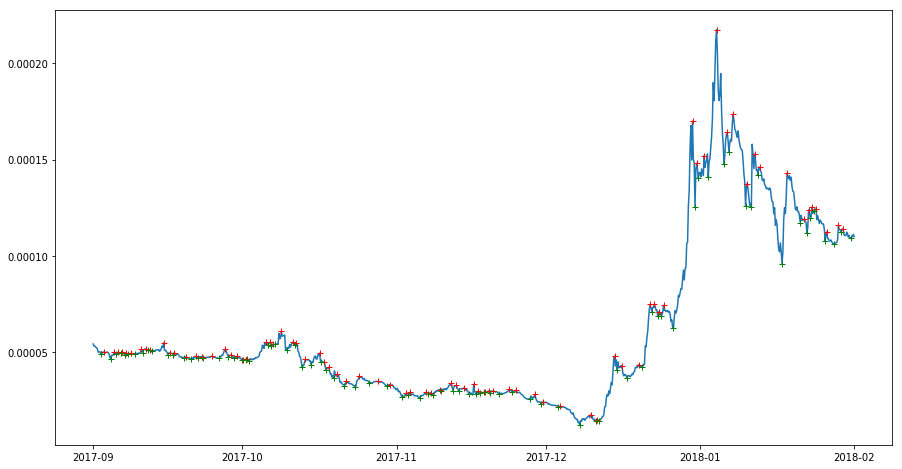

In [61]:
from mldata import ml_data
from orders import orders

df["ml_data"] = ml_data(df["close"])

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"] ,"sma13ema5":w["w"],"price_sma20":w3["w"],"price_ema5":w2["w"],
                          "ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"]})

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]
#train = data.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:][1:]
#test = data.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
print len(train),len(test)

# Creando modelo de regresion logistica utilizando sticklearn

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# Estas dos últimas librerías permiten la creación de una 
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
# "price","volumen","rsi","macd","macds","sma13ema5","price_sma20","price_ema5","ideal_w","cci","diff","wr"
features = ["price","rsi","cci"]

# regresion logistica
logreg = LogisticRegression()

# entrenando modelos
logreg.fit(train[features],train["ideal_w"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
# random forests
random_forest = RandomForestClassifier(n_estimators=10)

random_forest.fit(train[features],train["ideal_w"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
# knn
knn = KNeighborsClassifier(n_neighbors = 30)

knn.fit(train[features],train["ideal_w"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [65]:
# Neural network

# MLPClassifier

mlpc = MLPClassifier(hidden_layer_sizes = (100,))

mlpc.fit(train[features],train["ideal_w"])

# BernoulliRBM

rbm = BernoulliRBM()
logistic = LogisticRegression()
classifier = Pipeline([("rbm",rbm),("logistic",logistic)])
classifier.fit(train[features],train["ideal_w"])

Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=256, n_iter=10,
       random_state=None, verbose=0)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## probando modelo en otros datos

Retorno del mercacdo: 6.31039814457
Retorno de SMA13 VS EMA5: -4.67151286708
Retorno de Precio VS SMA20: -6.95359911437
Retorno de Precio VS EMA5: 25.1172339167
Retorno de ML_logreg: 5.87408414333
Retorno de ML_randfor: -1.36172377662
Retorno de ML_knn: 2.04682367121
Retorno de ML_mlpc: -6.80887162093
Retorno de ML_Boltzman: 10.0222705428


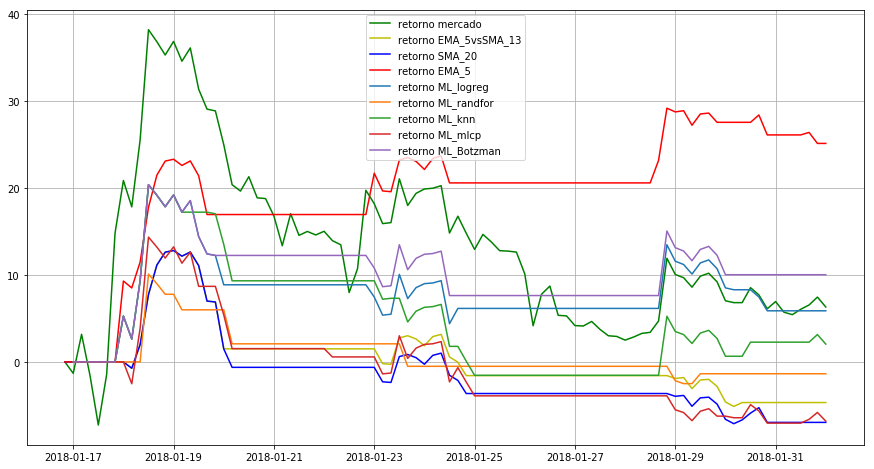

In [66]:
# regresion logistica
w_pred = logreg.predict(test[features])

w5 = pd.DataFrame(data={"w":w_pred,"price":test["close"]})
w5["orders"] = orders(w5["w"])
w5["w"] = w5["w"].shift(1)
relativeReturn5, v5 = profit(w5)

# random forest
w_pred2 = random_forest.predict(test[features])

w6 = pd.DataFrame(data={"w":w_pred2,"price":test["close"]})
w6["orders"] = orders(w6["w"])
w6["w"] = w6["w"].shift(1)
relativeReturn6, v6 = profit(w6)

# knn
w_pred3 = knn.predict(test[features])

w7 = pd.DataFrame(data={"w":w_pred3,"price":test["close"]})
w7["orders"] = orders(w7["w"])
w7["w"] = w7["w"].shift(1)
relativeReturn7, v7 = profit(w7)

# mlpc
w_pred4 = mlpc.predict(test[features])

w8 = pd.DataFrame(data={"w":w_pred4,"price":test["close"]})
w8["orders"] = orders(w8["w"])
w8["w"] = w8["w"].shift(1)
relativeReturn8, v8 = profit(w8)

# rbm
w_pred5 = classifier.predict(test[features])

w9 = pd.DataFrame(data={"w":w_pred5,"price":test["close"]})
w9["orders"] = orders(w9["w"])
w9["w"] = w9["w"].shift(1)
relativeReturn9, v9 = profit(w9)


print 'Retorno del mercacdo: %s'%(marketReturn2)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturnTest*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3Test*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2Test*100)
print 'Retorno de ML_logreg: %s'%(relativeReturn5*100)
print 'Retorno de ML_randfor: %s'%(relativeReturn6*100)
print 'Retorno de ML_knn: %s'%(relativeReturn7*100)
print 'Retorno de ML_mlpc: %s'%(relativeReturn8*100)
print 'Retorno de ML_Boltzman: %s'%(relativeReturn9*100)

plt.plot(df.index[int(len(data)*per):],cum_return2*100,'g', label='retorno mercado')
plt.plot(df.index[int(len(data)*per):],vTest*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[int(len(data)*per):],v3Test*100,'b',label='retorno SMA_20')
plt.plot(df.index[int(len(data)*per):],v2Test*100,'r',label='retorno EMA_5')
plt.plot(df.index[int(len(data)*per):],v5*100,label='retorno ML_logreg')
plt.plot(df.index[int(len(data)*per):],v6*100,label='retorno ML_randfor')
plt.plot(df.index[int(len(data)*per):],v7*100,label='retorno ML_knn')
plt.plot(df.index[int(len(data)*per):],v8*100,label='retorno ML_mlcp')
plt.plot(df.index[int(len(data)*per):],v9*100,label='retorno ML_Botzman')

plt.legend(loc='best')
plt.grid()


In [67]:
from strategy import ml_logreg

# Caracteristicas sobre las que se entrenara el modelo
feature_dic = {"rsi":stock["rsi_14"],"cci":stock["cci"],"price":df["close"]}

# Creando vector de pesos utilizando estrategia de ML de regresión logística
w_logreg = ml_logreg(df["close"],per=0.9,**feature_dic)

# Calculando retorno
relativeReturn6, v6 = profit(w_logreg)

print 'Retorno de ML_strategy: %s'%(relativeReturn6*100)

Retorno de ML_strategy: 5.87408414333


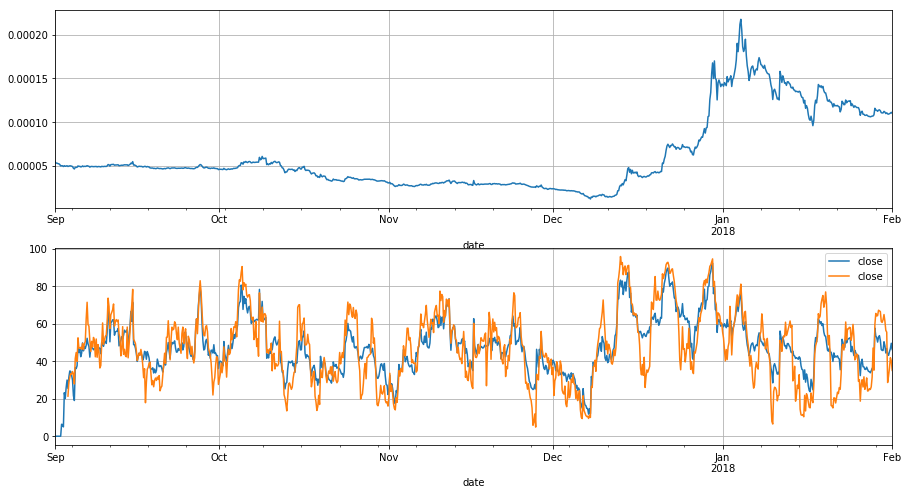

In [68]:
from indicators import rsi

RSI1, RSI2 = rsi(df["close"])

RSI1.head()

plt.subplot(211)
#plt.plot(df.index[1:],df['close'][1:],'r', label='precio')
plt.legend(loc='best')
df["close"].plot()
plt.grid()

plt.subplot(212)
RSI1.plot()
RSI2.plot()
plt.legend(loc='best')
plt.grid()